# KLUE-TC(YNAT) dataset (2800개)

- Labeling Error - 1000개는 라벨을 임의로 바꿈
→ 올바른 라벨로 재맵핑 필요
- Random Noise - 1600개는 text에 노이즈를 추가. 임의의 char 중 20~80%를 랜덤으로 다른 아스키코드로 대체
→ 높은 노이즈를 가지는 text는 제외, 낮은 샘플은 복구가 필요
→ 사람이 개별 판단하지 말 것. 자동 detection이 가능하게 하여 수정하거나, 삭제하거나 진행
- Normal Dataset - 200개

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer
import platform
import matplotlib as mpl

In [2]:
if platform.system() == 'Darwin': # macOS인 경우
    plt.rcParams['font.family'] = 'AppleGothic'
    mpl.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data/train.csv'))
df.head()

,ID,text,target
0,ynat-v1_train_00000,정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보,4
1,ynat-v1_train_00001,K찰.국DLwo 로L3한N% 회장 2 T0&}송=,3
2,ynat-v1_train_00002,"m 김정) 자주통일 새,?r열1나가야1보",2
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,5
4,ynat-v1_train_00004,pI美대선I앞두고 R2fr단 발] $비해 감시 강화,6


In [4]:
# 화살표가 포함된 행을 필터링
arrows = ['→', '←', '↑', '↓', '↔']
mask = df['text'].str.contains('|'.join(arrows))  # 화살표 기호가 포함된 행 찾기
df_with_arrows = df[mask]

# 결과 출력
df_with_arrows.head()

,ID,text,target
134,ynat-v1_train_00134,코오롱플라스틱 1분기 연결 영업익 58억원…138%↑,6
154,ynat-v1_train_00154,[반기 전}FjQQ 74Q여z…L년보~ 3.1%↓,5
156,ynat-v1_train_00156,GS칼텍스 IBK기업은행과 세터 이나연↔이고은 트레이드,5
169,ynat-v1_train_00169,e5 >사채 @행V0.9조원…Or대비O55z↑,5
186,ynat-v1_train_00186,KB증권 농심 4분기 라면 부문 실적개선…목표주가↑,6


In [5]:
# 공백으로 대체
df['text'] = df['text'].str.replace('…', ' ', regex=False)
df['text'] = df['text'].str.replace('...', ' ', regex=False)
df['text'] = df['text'].str.replace('·', ' ', regex=False)
# 화살표 기호 의미 대체
df['text'] = df['text'].str.replace('→', '에서', regex=False)
df['text'] = df['text'].str.replace('↑', '상승', regex=False)
df['text'] = df['text'].str.replace('↓', '하락', regex=False)
df['text'] = df['text'].str.replace('↔', ' ', regex=False)

In [6]:
# 정규 표현식 정의: 소수점 뒤에 숫자가 있으며, 그 뒤에 '%'가 있는 패턴
pattern = r'\d+\.\d+%'

# '.숫자%' 구성으로 이루어진 데이터 필터링
df_filtered = df[df['text'].str.contains(pattern, regex=True)]

# 결과 출력
df_filtered.head()

,ID,text,target
133,ynat-v1_train_00133,?씨D m년 h업8 16<K* h4.8%3,5
154,ynat-v1_train_00154,[반기 전}FjQQ 74Q여z L년보~ 3.1%하락,5
473,ynat-v1_train_00473,네이버 검색 광고 전체 광고 매출의 82.4% 차지,0
745,ynat-v1_train_00745,서울 표준주택 공시가 17.75%상승 15억 초과 고가주택 정밀 조준종합2보,4
929,ynat-v1_train_00929,(난해 OV은행 신용대w금리 3.2%p하락(#자 2천= 감소,5


In [7]:
# 특수 기호의 패턴 정의
# 이 예시에서는 영숫자 이외의 모든 기호를 특수 기호로 간주합니다.
# special_char_pattern = r'[^가-힣A-Z\u4E00-\u9FFF\s0-9]'
# .숫자% 형식을 제외하고, ㎜도 특수 기호에서 제외
special_char_pattern = r'(?<!\d)\.(?!\d)|(?<!\d)%|[^가-힣A-Z\u4E00-\u9FFF\s0-9\.%㎜㎡]'

# 각 text에 포함된 특수 기호의 개수를 세는 함수 정의
def count_special_characters(text):
    return len(re.findall(special_char_pattern, text))

# 데이터프레임에 새로운 열 추가
df['special_char_count'] = df['text'].apply(count_special_characters)
df['special_char_ratio'] = df['special_char_count'] / df['text'].str.len()

df_sorted = df.sort_values(by='special_char_ratio', ascending=False)

# 결과 출력
df_sorted.head()

,ID,text,target,special_char_count,special_char_ratio
624,ynat-v1_train_00624,"사건!>실""를 b$#라 #극)]체O.;월f:?",0,14,0.560000
2413,ynat-v1_train_02413,"전W;참c 이nd 유j]""m객ie((우려` ?<. 개조",6,16,0.533333
1203,ynat-v1_train_01203,nO통령z\후 p싱턴으로 ^R!與지p부 @re-#{{\,2,15,0.500000
2765,ynat-v1_train_02765,"$G ;!p 서울 |곳 나vo객 =적""bs 귀s,d거)",3,15,0.500000
2275,ynat-v1_train_02275,더*} ]i대+ 김현권!v원a}_대8*vdL줄!알았d,2,15,0.500000


In [8]:
# 출력 옵션을 설정하여 모든 행이 표시되도록 함
pd.set_option('display.max_rows', None)

# special_char_ratio가 0.2 이상인 데이터 필터링
noise_df = df_sorted[df_sorted['special_char_ratio'] >= 0.042]
print(len(noise_df))

# 결과 출력
noise_df.head()

# 출력 옵션을 원래대로 복구
pd.reset_option('display.max_rows')

1595


In [9]:
# df_high_ratio의 인덱스를 이용하여 제외할 행을 찾음
clean_df = df[~df.index.isin(noise_df.index)]

print(len(clean_df))
clean_df.head()

1205


,ID,text,target,special_char_count,special_char_ratio
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩,5,0,0.0
5,ynat-v1_train_00005,美성인 6명 중 1명꼴 배우자 연인 빚 떠안은 적 있다,0,0,0.0
7,ynat-v1_train_00007,아가메즈 33득점 우리카드 KB손해보험 완파 3위 굳,4,0,0.0
8,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요 경주 지진현장 방문종합,6,0,0.0
9,ynat-v1_train_00009,듀얼심 아이폰 하반기 출시설 솔솔 알뜰폰 기대감,4,0,0.0


# Sparse Embedding + PCA + K-Means 실험

## TF-IDF

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text'])
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
pca = PCA(n_components=2, random_state=42)
kmeans = KMeans(n_clusters=7, random_state=42)

In [12]:
def decompose_pca_with_kmeans(target, embedding_type: str) -> np.ndarray:
    target_pca = pca.fit_transform(target)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=target_pca[:, 0], y=target_pca[:, 1], hue=clean_df['target'], palette='Set1', s=100, alpha=0.6, edgecolor='w')
    plt.title(f'{embedding_type} 임베딩 이후 PCA 분석')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Actual Label')
    plt.show()
    return kmeans.fit_predict(target_pca)

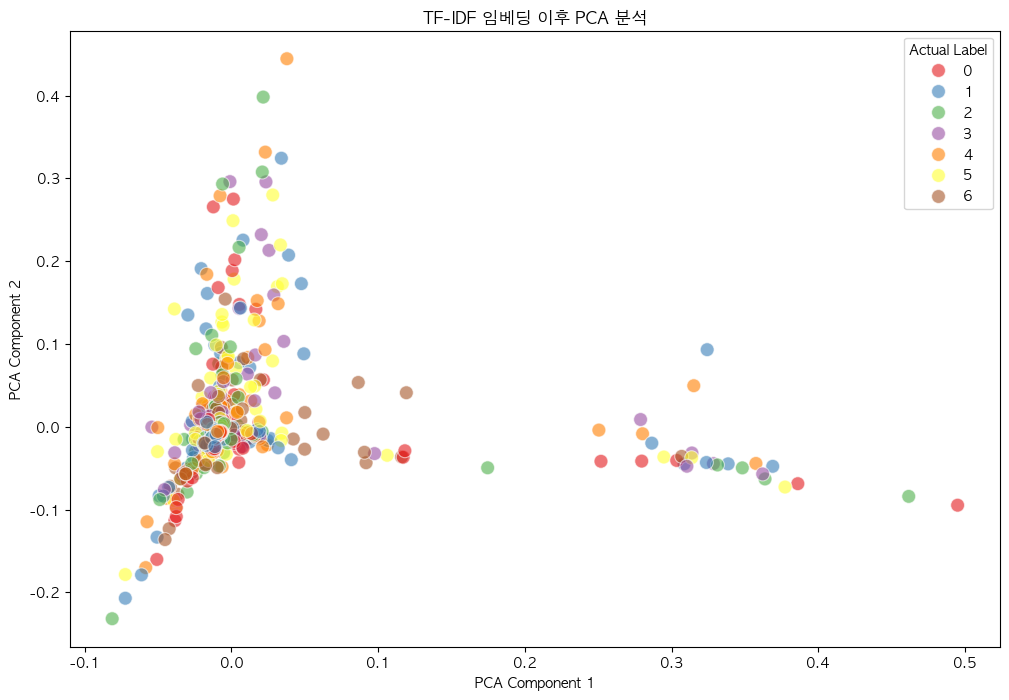

/var/folders/f9/7w3cw7_s6c7849zf1svk37000000gn/T/ipykernel_13839/1889195136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['cluster'] = decompose_pca_with_kmeans(X.toarray(), 'TF-IDF')


In [13]:
clean_df['cluster'] = decompose_pca_with_kmeans(X.toarray(), 'TF-IDF')

- 데이터가 원점에 몰려 있다. &rarr; 클러스터링이 잘 안 될 가능성이 높다.

In [14]:
label_map = {
    0:'생활문화',1:'스포츠',2:'정치',3:'사회',4:'IT과학',5:'경제',6:'세계'
}

def check_clustering():
    clean_df['label_match'] = clean_df['target'] == clean_df['cluster']
    mismatched_labels = clean_df[clean_df['label_match'] == False]
    mismatched_labels['target'] = mismatched_labels['target'].map(label_map)
    mismatched_labels['cluster'] = mismatched_labels['cluster'].map(label_map)
    return mismatched_labels

In [15]:
tfidf_mismatched_labels = check_clustering()

/var/folders/f9/7w3cw7_s6c7849zf1svk37000000gn/T/ipykernel_13839/462389004.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['label_match'] = clean_df['target'] == clean_df['cluster']
/var/folders/f9/7w3cw7_s6c7849zf1svk37000000gn/T/ipykernel_13839/462389004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_labels['target'] = mismatched_labels['target'].map(label_map)
/var/folders/f9/7w3cw7_s6c7849zf1svk37000000gn/T/ipykernel_13839/462389004.py:9: SettingWithCopyWarning: 
A value is 

In [16]:
print(f"잘못 라벨링된 데이터 수: {len(tfidf_mismatched_labels)}")
tfidf_mismatched_labels.head()

잘못 라벨링된 데이터 수: 1020


,ID,text,target,special_char_count,special_char_ratio,cluster,label_match
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩,경제,0,0.0,사회,False
7,ynat-v1_train_00007,아가메즈 33득점 우리카드 KB손해보험 완파 3위 굳,IT과학,0,0.0,생활문화,False
8,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요 경주 지진현장 방문종합,세계,0,0.0,생활문화,False
9,ynat-v1_train_00009,듀얼심 아이폰 하반기 출시설 솔솔 알뜰폰 기대감,IT과학,0,0.0,생활문화,False
11,ynat-v1_train_00011,NH투자 1월 옵션 만기일 매도 우세,스포츠,0,0.0,생활문화,False


- 직접 비교해본 결과, 정확도가 떨어진다. 1000개 데이터 이상치를 발견한 것은 우연인 듯하다.

## BM25

In [17]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
tokenized_corpus = [tokenizer.tokenize(text) for text in clean_df['text']]
bm25 = BM25Okapi(tokenized_corpus)
bm25_weights = [bm25.get_scores(doc) for doc in tokenized_corpus]

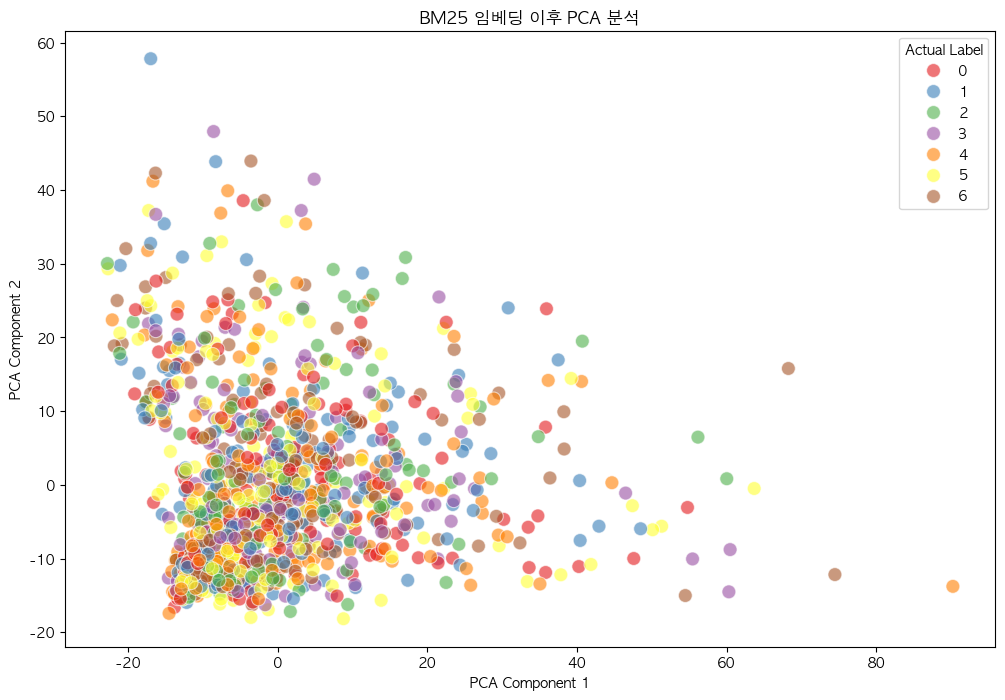

/var/folders/f9/7w3cw7_s6c7849zf1svk37000000gn/T/ipykernel_13839/3196284622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['cluster'] = decompose_pca_with_kmeans(bm25_weights, 'BM25')


In [18]:
clean_df['cluster'] = decompose_pca_with_kmeans(bm25_weights, 'BM25')

In [19]:
bm25_mismatched_labels = check_clustering()

/var/folders/f9/7w3cw7_s6c7849zf1svk37000000gn/T/ipykernel_13839/462389004.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['label_match'] = clean_df['target'] == clean_df['cluster']
/var/folders/f9/7w3cw7_s6c7849zf1svk37000000gn/T/ipykernel_13839/462389004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_labels['target'] = mismatched_labels['target'].map(label_map)
/var/folders/f9/7w3cw7_s6c7849zf1svk37000000gn/T/ipykernel_13839/462389004.py:9: SettingWithCopyWarning: 
A value is 

In [20]:
print(f"잘못 라벨링된 데이터 수: {len(bm25_mismatched_labels)}")
bm25_mismatched_labels.head()

잘못 라벨링된 데이터 수: 1022


,ID,text,target,special_char_count,special_char_ratio,cluster,label_match
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩,경제,0,0.0,세계,False
5,ynat-v1_train_00005,美성인 6명 중 1명꼴 배우자 연인 빚 떠안은 적 있다,생활문화,0,0.0,사회,False
7,ynat-v1_train_00007,아가메즈 33득점 우리카드 KB손해보험 완파 3위 굳,IT과학,0,0.0,세계,False
9,ynat-v1_train_00009,듀얼심 아이폰 하반기 출시설 솔솔 알뜰폰 기대감,IT과학,0,0.0,스포츠,False
12,ynat-v1_train_00012,황총리 각 부처 비상대비태세 철저히 강구해야,정치,0,0.0,스포츠,False


TF-IDF와 마찬가지로 정확도가 떨어진다. K-Means 알고리즘 대신 DBSCAN을 사용한다.
# 클러스터링 기반 라벨링 확인 - DBSCAN